Github Repo: https://github.com/NealRyan/Drug-drug-interaction-modeling

Project Final Notebook: https://github.com/NealRyan/Drug-drug-interaction-modeling/blob/main/Final_Report_Simplified_DDI_Model.ipynb
Project Draft Notebook: https://github.com/NealRyan/Drug-drug-interaction-modeling/blob/main/Draft_Report_Simplified_DDI_Model.ipynb

# Introduction

##### Problem Background


When multiple drugs are used in treatment of a patient, there is a possibility drugs interact, potentially causing harmful effects.
To reduce drug development time and uncover negative interactions before human trials, clinicians need a way to predict these drug interactions. This problem is combinatorially difficult due to the massive number of drugs, variations in drug features such as molecular structure, and the range of potential interactions. By using neural networks, clinicians could uncover patterns in drug interaction, enabling better understanding of drug functionality on the body. This understanding could not only discover negative drug interactions, but also secondary use-cases of drugs for treatment.


Traditional model architectures, such as proposed by $Rohani^{1}$ utilize drug-similarity matrices of features such as molecular substructure to predict interactions. These matrices are sub-selected for the most informative and fused into a singular matrix as input for a neural network. These approaches omit critical information about the kind of interactions between drugs, and simply discover any interaction. For clinicians to properly understand drug functionality and safety of use, they must be able to predict the severity and type of drug interactions.


Graph Neural Networks have recently been employed to encode and explore various drug interaction types. By encoding drugs as nodes, and interaction types as edges, models can better understand how drugs interact with one another. However, generating graph representations of drug interactions is challenging, particularly in how to combine various features from various sources and how to generate embeddings. $Lin et al^{2}$, generates a graph structure from various features, but only predicts the presence of an interaction from node locality - ignoring the semantic representation of features.


##### Paper Explanation

$Al-Rabeah^{3}$ improves upon both the traditional and GNN approaches by utilizing graph networks of various features to generate embeddings for feeding into a neural network for classification. The aim is to integrate both the similarity matrices of previous approaches with GNN embeddings of multiple featuresets, in order to represent a heterogeneous network for predicting the types of drug-drug interactions.


The work utilizes four feature matrices (Chemical structure, Target, Enzyme, and Pathway) as attributes for nodes representing drugs via similarity matrices, with edges being the drug-drug interaction. A graph is constructed for each feature matrix, and each graph is then used to generate an embedding matrix with a vector for each drug and interaction type. This is done via a random walk from the drug node utilizing edges of the given interaction type to form a node sequence, which is then used to learn embeddings. For each drug pair, the drug embedding vectors are element-wise multiplied with each other to represent drug-drug pairs. These vectors are then fed into the corresponding neural network, one for each graph, using a softmax to generate a probability vector over all event types. These probabilities are then averaged to produce a final prediction vector.


The work tested using all subsets of the feature matrices, with the best performance from using all four matrices gathered. The results, achieving 0.9206, 0.9992, 0.9717, 0.8579, and 0.8259 Accuracy, AUC, AUPR, F1, and recall scores respectively, outperformed many recent DDI works. This showed significant improvement over traditional Neural Network approaches, such as CNN-DDI by $Zhang^{4}$. While other GNN approaches, such as the novel KGNN, achieved better performance in some metrics such as F1 score - their analysis was over individual datasets and neglected several features. From this, the GNN-DDI architecture showed exceptional performance as it was faced with multiple-datasets, indicating strong usage across various features.


The work of $Al-Rabeah^{3}$ showed the strength of combining various feature sets for generating neural network inputs. Likewise, the paper exemplified the utility in combining multiple components of past approaches (GNN and fusion of multiple similarity matrix results) to produce a robust architecture performant over features from multiple datasets.



# Scope of Reproducibility

All of our efforts, including this notebook, pre-computed models, processed data, etc. are located within [our teams Github repository](https://github.com/NealRyan/Drug-drug-interaction-modeling/blob/main). For our project, we utilized the [papers authors code repository](https://github.com/Mohammad-Hussain95/GNN_DDI/tree/main/).

The original code was written in Tensorflow and was extremely hard to understand and modify, using obscure, lengthy matrix transformations to perform general operations. We first re-implemented the entire code repository of the paper using PyTorch.  By re-writing in PyTorch, we found it easier to implement various modifications/ablations within the original codebase.

## Architecture Modifications

Base on our best interpreations of the authors, we made several changes to the papers implementation to better fit the goal of predicting drug interactions:

* The similarity matrices used are a series of Jaccard similarity followed by PCA. We implemented PCA and use the PCA'd similarity matrices for generating our graph embeddings. The PCA step was omitted in both the paper and the original repository.
* In the original work, the graph network for generating embeddings was trained on positive interactions and didn't account for a lack of interaction betwen drugs. As a result, the dense network is also only trained on positive examples. We assume this to be a flaw in the design, skewing model performance towards the most common interaction events. We opted to balance the dataset with positive and negative interactions for DNN training.
* As a result of the above, we expanded our output vector from 65->66 to account for the non-interaction "event".
* We opted to average the output metrics to account for our new non-interaction class and the severe class imbalance. Using a weighted average does bias the model somewhat given the low prevelance of some events.


## Experiments / Hypothesis / Ablations

We tested the following hypothesis, experiments, and ablations listed below. See the Results section for a summary of the testing experiments.

1. Hyperparameter Tuning.
   By varying the below hyperparameters, we attempt to achieve a higher performance from the model. The paper performs minimal hyperparameter tuning, so we anticipate minor tuning to significantly improve performance. In addition, the original paper uses the Adam optimizer which is relatively fast to converge on local minima. By optimizing parameters, we could achieve a better minimum for training our models.
   - Layer size
       - Varying the sizes of intermediary layers can constrain the model's performance to fit to training data. By reducing intermediary layer size, we can have a looser bias to the training set. This could be used to lower dropout rate, enabling faster training without sacrificing model generalization.
   - Number of dense layers
       - The dataset utilized by the paper is unbalanced leading to underfitting. We anticipate increasing the number of dense layers (2) within the neural networks will result in a more biased model - which could better fit the intricacies of less prevalent drug-drug interactions.
   - Dropout rate
       - The paper uses a dropout rate of 0.3 to inject random noise and reduce bias. By modifying dropout rate, alongside changes to layer size, we anticipate the same model generalization with improved fitting to training data.
2. Removing Dropout, and replacing with optimizer weight decay.
   Dropout introduces randomness into the network, while weight decay promotes a balanced model by regulating heavy weights. We anticipate weight decay to more effectively account for relations in similarity matrices, particularly for interactions less present in the training set, leading to a higher CV score.
3. Replacing the Adam optimizer with SGD.
   The paper did not tune the parameters of the Adam optimizer, which likely led to convergence on a suboptimal minima. SGD is less likely to converge on these minima, and should result in better generalizability than untuned Adam.
4. Removal of dropout layers.
   The proposed GNN relies on two hidden-layer 0.3 rate dropout layers to prevent overfitting. We will test the removal of each hidden layer, as well as both layers. By removing these layers, we can evaluate how tightly model overfits to the similarity matrices.
5. Removal of early stopping.
   The code utilizes early stopping to prevent model overfitting if performance doesn’t improve in 10 epochs. We will remove this limitation, and attempt to overfit our network while retaining dropout. This will help evaluate how injected noise impacts performance.
6. Combining of 4 feedforward networks into 1.
   The paper uses 4 feedforward networks to evaluate each property type independently and aggregates the results, however this does not capture any interactions between property types. We will test concatenating the feature vectors from each property type and using a single feedforward network with this feature vector.



# Methodology

Directly below we cover our data and how we processed it. Further in the notebook (near the relevant code cells) we explain our models, model training, and evaluation.

## Data

### Data Descriptions

The paper utilizes four 2-D feature matrices of 572 drugs, derived from different databases:
* Chemical Structure
   - SMILE strings, ASCII representations, of drug molecule structures. Commonly used to encode molecular structure.
* Target
   - The molecule in the body which drug is intended to impact.
* Enzyme
   - The enzyme responsible for processing a drug within the body. Enzymes can degrade molecules into derivatives.
* Pathway
   - The specific pathway through which drugs are absorbed, distributed, metabolized, and excreted from the body.

All feature matrices were derived from the DrugBank database, and sourced from $Deng et al^{5}$ as an _eventdb_. The Pathway feature matrix also includes data from the KEGG database, also encoded in eventdb. Eventdb can be found at [this link as a SQLLiteDB](https://github.com/YifanDengWHU/DDIMDL/blob/master/event.db) and can be queried as a SQLLite database. In our preprocessing code below, we select all data from two tables within the eventdb: DRUG and INTERACTION. The DRUG table contains the 572 drugs and the attributes above (as | delineated strings). We use the DRUG table to derive the 4 matrices listed above. Each row in the matrices represents an individual drug, while the columns are 1-hot encodings of the presence of drug properties. As a result, each matrix varies in the length of the second axis.

To achieve a representation of drug similarity, these feature matrices are transformed into similarity matrices via a Jaccard similarity function. This results in uniform 572x572 similarity feature matrices. These similarity matrices were provided, however we also utilized our own code to derive these matrices. PCA analysis was then done on the similarity matrices, and the resulting matrices become the node attributes for our various graphs.


In addition, the paper utilizes an interaction matrix, describing 65 types of interactions between the 572 drugs (as well as no interaction). This matrix is derived from the INTERACTION table of eventdb. These 65 (66 including no interaction) types are the types of DDI events extracted by $Deng et al^{5}$. This matrix is used to create the edges of our drug graphs.
The matrix has 4 dimensions:
- Drug 1
- Drug 2
   * Note, since there is no causal relationship between the drugs, Drug 1 and Drug 2 for a given row can be swapped.
- Mechanism of drug interaction
- If interaction is increased or decreased

From this, the paper can derive two submatrices: the presence of drug interactions and interaction types. The distribution of the data is extremely uneven across event types, resulting in underfitting to the less represented events. This fact informed the basis of many of our experiments - as we try to appropriately fit the model for these events.

We perform analysis over these different matrices in the below sections.


# Environment Setup

* Please use Python v3.10.12. We recommend using a clean virtual environment for dependency isolation.
* The below cell lists required dependencies, run the cell to install.

In [1]:
!pip install absl-py==1.4.0
!pip install google-auth
!pip install torch==2.2.1+cu121 -f https://download.pytorch.org/whl/cu121/torch_stable.html
!pip install torch-geometric
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.1+cu121.html
!pip install requests
!pip install pandas
!pip install scikit-learn
!pip install matplotlib



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/cu121/torch_stable.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


##### Import Libraries

In [2]:
import requests
import pandas as pd
import numpy as np
import math
import sqlite3
import torch
from torch_geometric.data import Data
from torch_geometric.nn import Node2Vec
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from collections import defaultdict
from operator import index
from six import iteritems
import time

_USING_COLAB = False

try:
    from google.colab import files
    _USING_COLAB = True
except ModuleNotFoundError as e:
    # Not running in colab
    pass
    

print(torch.__version__)
print(torch.version.cuda)

2.2.1+cu121
12.1


### Notebook Configuration

This paper has several steps including:
* Download event_db and extract raw drug attributes and interaction data.
* Train GNN models and generate graph embeddings
* Train NN

For ease of running, we will enable feature_flags, selecting to either fully run each step OR download from precomputed sources. Any step can be toggled on/off in the below cell. The precomputed resources are stored in [our teams github repository](https://github.com/NealRyan/Drug-drug-interaction-modeling/tree/main).

For the best performance, use precomputed data by setting flags to default values provided below.

##### Set Control Flags

In [3]:
TRAIN_GNN = False # default: False
TRAIN_DNN = False # default: False

USE_GIVEN_DATA = True # default: True

DOWNLOAD_MODELS = False # default: False

##### Download and Process Data

##### Helper Functions

In [4]:
def download_file(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)

def read_data(file_path):
    with open(file_path, 'r') as file:
        return [line.strip().split() for line in file.readlines()]

def download_model_file(url, filename):
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

##### Datapaths

In [5]:
urls = {
    'train': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/data5/train.txt',
    'test' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/data5/test.txt',
    'valid' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/data5/valid.txt',
    'full_pos2': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/full_pos2.txt',
    'all_neg2': 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/all_neg2.txt',
    'enzyme' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Similarity%20Matrices/enzyme.txt',
    'pathway' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Similarity%20Matrices/pathway.txt',
    'substructure' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Similarity%20Matrices/substructure.txt',
    'target' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Similarity%20Matrices/target.txt',
    'drugs' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Encoded%20Features%20Data/DrugList.txt',
    'events' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Encoded%20Features%20Data/event_number.csv',
    'enzyme_pca' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/enzyme_PCA.csv',
    'pathway_pca' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/pathway_PCA.csv',
    'substructure_pca' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/smile_PCA.csv',
    'target_pca' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/target_PCA.csv',
    'eventdb' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Raw%20Event%20DB/event.db'
    #'walks' : 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Original%20Code/DDI/data5/walks.txt'
}

model_urls = {
    'enzyme_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/enzyme_model_best_model.pth',
    'pathway_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/pathway_model_best_model.pth',
    'substructure_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/substructure_model_best_model.pth',
    'target_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/target_model_best_model.pth',
    'raw_data_enzyme_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/raw_data_enzyme_model_best_model.pth',
    'raw_data_pathway_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/raw_data_pathway_model_best_model.pth',
    'raw_data_substructure_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/raw_data_substructure_model_best_model.pth',
    'raw_data_target_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/raw_data_target_model_best_model.pth',
    'all_model_best_model': 'https://github.com/NealRyan/Drug-drug-interaction-modeling/raw/main/Model%20Files/all_model_best_model.pth'
}

##### Download

In [6]:
# Download the text files
for key, url in urls.items():
    download_file(url, f"{key}.txt")

In [7]:
# Download the models
for key, url in model_urls.items():
    download_file(url, f"{key}.pth")

### Extract Raw Feature Data

Download and extract raw feature data from event_db (from Deng et al) and convert into the required Jacard similarity matrices.

In [8]:
conn = sqlite3.connect('./eventdb.txt')

df_raw_drug = pd.read_sql('select * from drug;', conn)
df_raw_extraction = pd.read_sql('select * from extraction;', conn)
#df_raw_event = pd.read_sql('select * from event;', conn)
#df_raw_event_num = pd.read_sql('select * from event_number;', conn)

# close the DB connection
conn.close()

In [9]:
def dict_from_set(in_set):
    ret_dic = {}
    count = 0
    for val in in_set:
        ret_dic[val] = count
        count += 1

    return ret_dic

def index_list_from_str_list(str_list, str_dict):
    ret_list = []
    for s in str_list:
        ret_list.append(str_dict[s])

    return ret_list

targets = set()
enzymes = set()
pathways = set()
smiles = set()

for index, row in df_raw_drug.iterrows():
    target_list = row['target'].split('|')
    enzyme_list = row['enzyme'].split('|')
    pathways_list = row['pathway'].split('|')
    smiles_list = row['smile'].split('|')

    targets.update(target_list)
    enzymes.update(enzyme_list)
    pathways.update(pathways_list)
    smiles.update(smiles_list)

targets_dic = dict_from_set(targets)
enzymes_dic = dict_from_set(enzymes)
pathways_dic = dict_from_set(pathways)
smiles_dic = dict_from_set(smiles)

targets_jac = np.zeros((len(df_raw_drug.index), len(targets)))
enzymes_jac = np.zeros((len(df_raw_drug.index), len(enzymes)))
pathways_jac = np.zeros((len(df_raw_drug.index), len(pathways)))
smiles_jac = np.zeros((len(df_raw_drug.index), len(smiles)))

for index, row in df_raw_drug.iterrows():
    targets_jac[index, index_list_from_str_list(row['target'].split('|'), targets_dic)] = 1
    enzymes_jac[index, index_list_from_str_list(row['enzyme'].split('|'), enzymes_dic)] = 1
    pathways_jac[index, index_list_from_str_list(row['pathway'].split('|'), pathways_dic)] = 1
    smiles_jac[index, index_list_from_str_list(row['smile'].split('|'), smiles_dic)] = 1

jac_sim_target = 1 - pairwise_distances(targets_jac, metric='jaccard')
jac_sim_enzyme = 1 - pairwise_distances(enzymes_jac, metric='jaccard')
jac_sim_pathways = 1 - pairwise_distances(pathways_jac, metric='jaccard')
jac_sim_smiles = 1 - pairwise_distances(smiles_jac, metric='jaccard')

target_PCA = PCA(n_components=len(jac_sim_target))
enzyme_PCA = PCA(n_components=len(jac_sim_enzyme))
pathway_PCA = PCA(n_components=len(jac_sim_pathways))
smile_PCA = PCA(n_components=len(jac_sim_smiles))

target_PCA.fit(jac_sim_target)
jac_sim_df_target = pd.DataFrame(target_PCA.transform(jac_sim_target))

enzyme_PCA.fit(jac_sim_enzyme)
jac_sim_df_enzyme = pd.DataFrame(enzyme_PCA.transform(jac_sim_enzyme))

pathway_PCA.fit(jac_sim_pathways)
jac_sim_df_pathways = pd.DataFrame(pathway_PCA.transform(jac_sim_pathways))

smile_PCA.fit(jac_sim_smiles)
jac_sim_df_smiles = pd.DataFrame(smile_PCA.transform(jac_sim_smiles))

#print(jac_sim_df_target.head())

/home/bjones/.local/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/bjones/.local/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/bjones/.local/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/bjones/.local/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### Extract drug event type interactions from event_db (from Deng et al)

These interactions will be used to form our positive examples, negative examples, and a complete list of drug-drug interactions for use in generating our graph embedding.

In [10]:
df_raw_drug_name = df_raw_drug.set_index('name')

df_raw_extraction['event'] = df_raw_extraction['mechanism'] + ' ' + df_raw_extraction['action']

df_raw_events = df_raw_extraction['event'].value_counts().to_frame()
df_raw_events['event_index'] = np.arange(df_raw_events.shape[0])

df_raw_full_pos = df_raw_extraction.join(df_raw_events, on='event')[['drugA', 'drugB', 'event_index']]
df_raw_full_pos = df_raw_full_pos.join(df_raw_drug_name['index'], on='drugA')
df_raw_full_pos = df_raw_full_pos.join(df_raw_drug_name['index'], on='drugB', rsuffix='_drugB')
df_raw_full_pos = df_raw_full_pos[['event_index', 'index', 'index_drugB']]

df_raw_events = df_raw_events.reset_index()[['event', 'count']]

used_pairs = np.identity(len(df_raw_drug_name.index))
# could also sort ints to ensure consistent ordering instead of making matrix symmetrical
for index, row in df_raw_full_pos.iterrows():
    used_pairs[row['index'], row['index_drugB']] = 1
    used_pairs[row['index_drugB'], row['index']] = 1

df_raw_all_neg = np.zeros((len(df_raw_full_pos.index), 2))

count = 0
while count < len(df_raw_all_neg):
    # could also sort ints to ensure consistent ordering instead of making matrix symmetrical
    rand_pair = np.random.randint(len(df_raw_drug_name.index), size=2)
    while used_pairs[rand_pair[0], rand_pair[1]] == 1 or used_pairs[rand_pair[1], rand_pair[0]] == 1:
        rand_pair = np.random.randint(len(df_raw_drug_name.index), size=2)

    used_pairs[rand_pair[0], rand_pair[1]] = 1
    used_pairs[rand_pair[1], rand_pair[0]] = 1
    df_raw_all_neg[count] = rand_pair
    count += 1

df_raw_all_neg = pd.DataFrame(df_raw_all_neg, columns=['drug1', 'drug2'], dtype=np.int64)
df_raw_full_pos = df_raw_full_pos.rename(columns={'event_index': 'event_num', 'index': 'drug1', 'index_drugB': 'drug2'})

#print(df_raw_full_pos.head())
#print(df_raw_all_neg.head())
#print(df_raw_events)

In [63]:
def save_similarity_matrix(name, matrix):
    file_path = f'./{name}.txt'

    with open(file_path, 'w') as file:
        file.write('572 572\n')
        for index, row in matrix.iterrows():
            file.write(f'{index} ')
            file.write(" ".join(str(val) for val in row.tolist()) + '\n')

if not USE_GIVEN_DATA:
    save_similarity_matrix('enzyme', jac_sim_df_enzyme)
    save_similarity_matrix('target', jac_sim_df_target)
    save_similarity_matrix('pathway', jac_sim_df_pathways)
    save_similarity_matrix('substructure', jac_sim_df_smiles)

##### Process similarity matrices

In [12]:
import pandas as pd

def load_similarity_matrix(file_path):
    file_name = file_path.split('/')[-1]  #Get just file name from path

    with open(file_path, 'r') as file:
        lines = file.readlines()
        #take the first line as the dimensions
        dimensions = lines[0].strip().split()
        rows, cols = int(dimensions[0]), int(dimensions[1])
        print(f'Working on {file_name}: dimensions {rows}x{cols}')

        #the rest of the lines contain the matrix
        data = []
        for i, line in enumerate(lines[1:]):
            row_data = line.strip().split()[1:]  # Skip the row number

            #convert to float and handle scientific notation
            try:
                row_data = [float(x) for x in row_data]
            except ValueError as e:
                print(f"Error in line {i+2}: {e}")
                continue

            if len(row_data) != cols:
                raise ValueError(f"Row {i+2} does not contain {cols} values. Row data: {row_data}")

            data.append(row_data)

        # Convert to DataFrame
        matrix = pd.DataFrame(data)
        if matrix.shape != (rows, cols):
            raise ValueError(f"Data does not match specified dimensions {rows}x{cols}")
        return matrix

enzyme_matrix = load_similarity_matrix('./enzyme.txt')
pathway_matrix = load_similarity_matrix('./pathway.txt')
substructure_matrix = load_similarity_matrix('./substructure.txt')
target_matrix = load_similarity_matrix('./target.txt')


print('Enzyme Matrix first 5 lines:')
print(enzyme_matrix.head())

Working on enzyme.txt: dimensions 572x572
Working on pathway.txt: dimensions 572x572
Working on substructure.txt: dimensions 572x572
Working on target.txt: dimensions 572x572
Enzyme Matrix first 5 lines:
        0         1         2         3         4         5         6    \
0  4.593168 -0.541539 -0.419176 -0.585470  0.635045 -0.553429 -0.638244   
1 -1.746907 -0.047556  0.115552  0.256290  0.833815  0.055187 -0.252872   
2 -1.604115  0.854200  0.054576  0.923948 -0.645173 -0.069596 -0.404109   
3 -1.769781 -0.921454 -0.756435 -0.686417  0.678216 -0.013575  0.142495   
4  3.707746  2.830004 -0.844595  0.383860 -0.122485 -0.528834  0.652127   

        7         8         9    ...           562           563  \
0  0.058711  0.458386  0.214047  ...  0.000000e+00 -4.857226e-17   
1  0.095018 -0.013088  0.119412  ...  3.209238e-17 -1.561251e-17   
2 -0.331794  0.545126  0.175939  ... -1.561251e-17  1.734723e-18   
3 -0.032153 -0.427615 -0.124185  ...  6.938894e-18  1.023487e-16   
4  0.

## Process training and test data

In [13]:
# Define a function to load the data into a DataFrame and label the columns
def load_data(file_path, has_interaction=True, has_event_num=True):
    #testing data, which can have 0 or 1 interactions
    if has_event_num and has_interaction:
        column_names = ['event_num', 'drug1', 'drug2', 'interaction']
    #training data which does not include interaction because it's always 1
    elif has_event_num:
        column_names = ['event_num', 'drug1', 'drug2']
    #All neg which only contains drug1, drug 2 and no interactions or events
    else:
        column_names = ['drug1', 'drug2']

    data = pd.read_csv(file_path, sep=' ', header=None, names=column_names)

    return data

# Paths to the files in the Colab environment
test_file_path = './test.txt'
train_file_path = './train.txt'
valid_file_path = './valid.txt'
all_neg_file_path = './all_neg2.txt'
full_pos_file_path = './full_pos2.txt'

# Load the data into DataFrames
test_df = load_data(test_file_path, has_interaction=True)
train_df = load_data(train_file_path, has_interaction=False)
valid_df = load_data(valid_file_path, has_interaction=True)
all_neg_df = load_data(all_neg_file_path, has_interaction=False, has_event_num=False)
full_pos_df = load_data(full_pos_file_path, has_interaction=False)

# print("Test DataFrame:")
# print(test_df.head())
# print('\n')
# print("Train DataFrame:")
# print(train_df.head())
# print('\n')
# print(f'train drug1 range: {train_df.drug1.min()}-{train_df.drug1.max()}')
# print(f'train drug2 range: {train_df.drug2.min()}-{train_df.drug2.max()}')


#### Data Analysis

From our four raw features, we have the below unique values:
* 202 unique enzymes
* 1162 unique drug targets
* 583 unique smile paths
* 957 unqiue pathways

The distribution of target, smile, and pathways encodings are largely even. The distribution for enzymnes are skewed towards the most commonly impacted enzymes.

Following processing, all similarity matrices have a shape of 572x572. This is a result of the jaccard similarity, which we use to represent relationships between drug features. These matrices will be the node attributes within our GNNs to generate embeddings for prediction by our final models.

#### Interaction Analyis

As shown below, we have an even distribution of "positive" (interaction) and "negative" (no-interaction) events for 37264 each, with a total for 65 unique interaction types. However, we have a massive skew in interaction type (shown by index and head) with 3 interaction types accounting for 66% of the interactions. This massive skew will make it difficult for the model to train to less prevalent interactions.


In [14]:
print(f'Num target features: {len(targets)}')
print(f'Num enzyme features: {len(enzymes)}')
print(f'Num pathway features: {len(pathways)}')
print(f'Num substructure features: {len(smiles)}')

print("\nInteraction Types:")
print(df_raw_events.head())

Num target features: 1162
Num enzyme features: 202
Num pathway features: 957
Num substructure features: 583

Interaction Types:
                                              event  count
0                           The metabolism decrease   9810
1  The risk or severity of adverse effects increase   9496
2                  The serum concentration increase   5646
3                  The serum concentration decrease   2386
4                 The therapeutic efficacy decrease   1312


### Generate Train/Test/Validate Splits

We will now create our train, test, and validate splits from the drug-drug interaction dataframes we generated from the event_db.

We will use a standard (70-20-10, train, test, validation) split, giving us:
* 52169 training samples
* 14906 training samples
* 7453 validation samples

In [15]:
if not USE_GIVEN_DATA:
    full_pos_df = df_raw_full_pos
    all_neg_df = df_raw_all_neg

#select equal number of negative examples from all_neg_df
num_negatives = len(full_pos_df)
all_neg_sample = all_neg_df.sample(n=num_negatives, random_state=42)

# Add an 'event_num' column with a placeholder value
all_neg_sample['event_num'] = -1

#Combine positive and negative examples for neural network training
nn_data = pd.concat([full_pos_df, all_neg_sample]).reset_index(drop=True)

#split data into train, validation, and test sets (70-10-20 split)
train_df, test_df = train_test_split(nn_data, test_size=0.3, random_state=2)
valid_df, test_df = train_test_split(test_df, test_size=(2/3), random_state=2)  #split last 30% into 10% and 20% valid/test

test_df['interaction'] = test_df['event_num'].apply(lambda x: 1 if 0 <= x <= 64 else 0)

# Verify the splits
print(f"Train data size: {len(train_df)}")
print(f"Validation data size: {len(valid_df)}")
print(f"Test data size: {len(test_df)}")

Train data size: 52169
Validation data size: 7453
Test data size: 14906


### GNN Training for Embedding Extraction

We will create graph embeddings. These will serve as the drug feature vectors for use in our feed forward neural network. The original paper defines [their GNN model here](https://github.com/Mohammad-Hussain95/GNN_DDI/tree/main/GNN). The existing PyTorch implementation of the $GATNE^{6}$ embedding method found [here](https://github.com/THUDM/GATNE) was implemented below.

To generate our graph embeddings, we will make a graph of nodes (drugs) and edges (events - event num). Four graphs in total are made (one for each of the property types we want to make embeddings for - enzyme, pathway, substructure, and target). The features of the nodes in the graph will be a row of the feature matrix, corresponding to that drug's similarity to each of the other drugs in the network on that property type (enzyme for instance). A random walk of the graph with a context window is done for each drug and edge type to create one embedding per drug per interaction type.

The output dimension of these graph embeddings is 572x32x66 which corresponds to the number of drugs x the embedding dimension x the number of events. The embedding dimension is a tuned hyperparameter from the original work, but can theoretically be changed. Finally, the last two dimensions of these matrices will be concatenated to form raw feature vectors for the nerual network (of dimension 572x2080 where 2080=32x65). "Raw" because we will still need to perform some further operations before they are ready to go.

As mentioned above, the pre-generated embeddings will be used if the `TRAIN_GNN` control flag is set to `False`. The generated embeddings are available [at this link](https://github.com/NealRyan/Drug-drug-interaction-modeling/tree/main/Data/Embedding%20Matrices) as CSVs.

In [16]:
embedding_dim = 32  #Default 32
event_num = 65  #Default 65 DO NOT CHANGE

#Dictionary of feature matrices to use
#Not currently used

feature_matrices = {}
if USE_GIVEN_DATA:
    feature_matrices['enzyme'] = enzyme_matrix
    feature_matrices['pathway'] = pathway_matrix
    feature_matrices['substructure'] =  substructure_matrix
    feature_matrices['target'] = target_matrix
else:
    feature_matrices['enzyme'] = jac_sim_df_enzyme
    feature_matrices['pathway'] = jac_sim_df_pathways
    feature_matrices['substructure'] =  jac_sim_df_smiles
    feature_matrices['target'] = jac_sim_df_target


#Use GPU if available. This will be much faster for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [17]:
walk_length = 10 #Default 10
walks_per_node = 20 #Default 20
window_size = 5 #Default 5
negative_samples = 5 #Default 5
learning_rate = 0.01 #Default 0.01
epochs = 1 #Default 1
batch_size=64 #Default 64, lower this if RAM spikes are crashing Colab
num_workers=16 #Default 16
patience_num = 5 #no default (because we default to 1 epoch)
save_path = '/content'
edge_dim = 10 #Degault 10
att_dim = 20 #Default 20
negative_samples = 5 #Default 5
neighbor_samples = 20 #Default 10
eval_type = 'all'

##### Define graph edges
There are two choices for how to define the graph neural network:
* We can either include negative samples (drug-drug pairs that DO NOT interact with eachother)
* Omit negative examples.

The original paper does *not* use negative examples in training, and only includes negative samples in the validation and test sets. We will improve upon this by introducing a 50/50 split of positive and negative examples in our training data. It may be useful to use different splits of positive and negative examples for different models.

In [18]:
class Vocab(object):
    def __init__(self, count, index):
        self.count = count
        self.index = index

#Batches for training the GNN
def get_batches(pairs, neighbors, batch_size):
    n_batches = (len(pairs) + (batch_size - 1)) // batch_size

    for idx in range(n_batches):
        x, y, t, neigh = [], [], [], []
        for i in range(batch_size):
            index = idx * batch_size + i
            if index >= len(pairs):
                break
            x.append(pairs[index][0])
            y.append(pairs[index][1])
            t.append(pairs[index][2])
            neigh.append(neighbors[pairs[index][0]])
        yield torch.tensor(x), torch.tensor(y), torch.tensor(t), torch.tensor(neigh)

def get_G_from_edges(edges):
    edge_dict = defaultdict(set)
    for edge in edges:
        u, v = str(edge[0]), str(edge[1])
        edge_dict[u].add(v)
        edge_dict[v].add(u)
    return edge_dict

def load_training_data(f_name):
    print('Loading data from:', f_name)
    edge_data_by_type = dict()
    all_nodes = list()
    with open(f_name, 'r') as f:
        for line in f:
            words = line[:-1].split(' ')
            if words[0] not in edge_data_by_type:
                edge_data_by_type[words[0]] = list()
            x, y = words[1], words[2]
            edge_data_by_type[words[0]].append((x, y))
            all_nodes.append(x)
            all_nodes.append(y)
    all_nodes = list(set(all_nodes))
    print('Total training nodes: ' + str(len(all_nodes)))
    return edge_data_by_type


def load_testing_data(f_name):
    print('Loading data from:', f_name)
    true_edge_data_by_type = dict()
    false_edge_data_by_type = dict()
    all_nodes = list()
    with open(f_name, 'r') as f:
        for line in f:
            words = line[:-1].split(' ')
            x, y = words[1], words[2]
            if int(words[3]) == 1:
                if words[0] not in true_edge_data_by_type:
                    true_edge_data_by_type[words[0]] = list()
                true_edge_data_by_type[words[0]].append((x, y))
            else:
                if words[0] not in false_edge_data_by_type:
                    false_edge_data_by_type[words[0]] = list()
                false_edge_data_by_type[words[0]].append((x, y))
            all_nodes.append(x)
            all_nodes.append(y)
    all_nodes = list(set(all_nodes))
    return true_edge_data_by_type, false_edge_data_by_type

def load_node_type(f_name):
    print('Loading node type from:', f_name)
    node_type = {}
    with open(f_name, 'r') as f:
        for line in f:
            items = line.strip().split()
            node_type[items[0]] = items[1]
    return node_type

def load_feature_data(f_name):
    feature_dic = {}
    with open(f_name, 'r') as f:
        first = True
        for line in f:
            if first:
                first = False
                continue
            items = line.strip().split()
            feature_dic[items[0]] = items[1:]
    return feature_dic

def generate_walks(network_data, num_walks, walk_length, schema, file_name, num_workers):
    if schema is not None:
        node_type = load_node_type(file_name + '/node_type.txt')
    else:
        node_type = None

    all_walks = []
    for layer_id, layer_name in enumerate(network_data):
        tmp_data = network_data[layer_name]
        # start to do the random walk on a layer

        layer_walker = RWGraph(get_G_from_edges(tmp_data), node_type, num_workers)
        print('Generating random walks for event_num', layer_id)
        layer_walks = layer_walker.simulate_walks(num_walks, walk_length, schema=schema)

        all_walks.append(layer_walks)

    print('Finish generating the walks')

    return all_walks

def generate_pairs(all_walks, vocab, window_size, num_workers):
    pairs = []
    skip_window = window_size // 2
    for layer_id, walks in enumerate(all_walks):
        print('Generating training pairs for event_num', layer_id)
        for walk in tqdm(walks):
            for i in range(len(walk)):
                for j in range(1, skip_window + 1):
                    if i - j >= 0:
                        pairs.append((vocab[walk[i]].index, vocab[walk[i - j]].index, layer_id))
                    if i + j < len(walk):
                        pairs.append((vocab[walk[i]].index, vocab[walk[i + j]].index, layer_id))
    return pairs

def generate_vocab(all_walks):
    index2word = []
    raw_vocab = defaultdict(int)

    for layer_id, walks in enumerate(all_walks):
        print('Counting vocab for event_num', layer_id)
        for walk in tqdm(walks):
            for word in walk:
                raw_vocab[word] += 1

    vocab = {}
    for word, v in iteritems(raw_vocab):
        vocab[word] = Vocab(count=v, index=len(index2word))
        index2word.append(word)

    index2word.sort(key=lambda word: vocab[word].count, reverse=True)
    for i, word in enumerate(index2word):
        vocab[word].index = i

    return vocab, index2word

def load_walks(walk_file):
    print('Loading walks')
    all_walks = []
    with open(walk_file, 'r') as f:
        for line in f:
            content = line.strip().split()
            layer_id = int(content[0])
            if layer_id >= len(all_walks):
                all_walks.append([])
            all_walks[layer_id].append(content[1:])
    return all_walks

def save_walks(walk_file, all_walks):
    with open(walk_file, 'w') as f:
        for layer_id, walks in enumerate(all_walks):
            print('Saving walks for event_num', layer_id)
            for walk in tqdm(walks):
                f.write(' '.join([str(layer_id)] + [str(x) for x in walk]) + '\n')

def generate(network_data, num_walks, walk_length, schema, file_name, window_size, num_workers, walk_file):
    if walk_file is not None:
        all_walks = load_walks(walk_file)
    else:
        all_walks = generate_walks(network_data, num_walks, walk_length, schema, file_name, num_workers)
        save_walks(file_name + '/walks.txt', all_walks)
    vocab, index2word = generate_vocab(all_walks)
    train_pairs = generate_pairs(all_walks, vocab, window_size, num_workers)

    return vocab, index2word, train_pairs

def generate_neighbors(network_data, vocab, num_nodes, edge_types, neighbor_samples):
    edge_type_count = len(edge_types)
    neighbors = [[[] for __ in range(edge_type_count)] for _ in range(num_nodes)]
    for r in range(edge_type_count):
        print('Generating neighbors for event_num', r)
        g = network_data[edge_types[r]]
        for (x, y) in tqdm(g):
            ix = vocab[x].index
            iy = vocab[y].index
            neighbors[ix][r].append(iy)
            neighbors[iy][r].append(ix)
        for i in range(num_nodes):
            if len(neighbors[i][r]) == 0:
                neighbors[i][r] = [i] * neighbor_samples
            elif len(neighbors[i][r]) < neighbor_samples:
                neighbors[i][r].extend(list(np.random.choice(neighbors[i][r], size=neighbor_samples-len(neighbors[i][r]))))
            elif len(neighbors[i][r]) > neighbor_samples:
                neighbors[i][r] = list(np.random.choice(neighbors[i][r], size=neighbor_samples))
    return neighbors

def get_score(local_model, node1, node2):
    try:
        vector1 = local_model[node1]
        vector2 = local_model[node2]
        return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))
    except Exception as e:
        pass


def evaluate(model, true_edges, false_edges):
    true_list = list()
    prediction_list = list()
    true_num = 0
    for edge in true_edges:
        tmp_score = get_score(model, str(edge[0]), str(edge[1]))
        if tmp_score is not None:
            true_list.append(1)
            prediction_list.append(tmp_score)
            true_num += 1

    for edge in false_edges:
        tmp_score = get_score(model, str(edge[0]), str(edge[1]))
        if tmp_score is not None:
            true_list.append(0)
            prediction_list.append(tmp_score)

    sorted_pred = prediction_list[:]
    sorted_pred.sort()
    threshold = sorted_pred[-true_num]

    y_pred = np.zeros(len(prediction_list), dtype=np.int32)
    for i in range(len(prediction_list)):
        if prediction_list[i] >= threshold:
            y_pred[i] = 1

    y_true = np.array(true_list)
    y_scores = np.array(prediction_list)
    ps, rs, _ = precision_recall_curve(y_true, y_scores)
    return roc_auc_score(y_true, y_scores), f1_score(y_true, y_pred), auc(rs, ps)

In [19]:
import random
import multiprocessing

from tqdm import tqdm

def walk(args):
    walk_length, start, schema = args
    # Simulate a random walk starting from start node.
    rand = random.Random()

    if schema:
        schema_items = schema.split('-')
        assert schema_items[0] == schema_items[-1]

    walk = [start]
    while len(walk) < walk_length:
        cur = walk[-1]
        candidates = []
        for node in G[cur]:
            if schema == '' or node_type[node] == schema_items[len(walk) % (len(schema_items) - 1)]:
                candidates.append(node)
        if candidates:
            walk.append(rand.choice(candidates))
        else:
            break
    return [str(node) for node in walk]

def initializer(init_G, init_node_type):
    global G
    G = init_G
    global node_type
    node_type = init_node_type

class RWGraph():
    def __init__(self, nx_G, node_type_arr=None, num_workers=16):
        self.G = nx_G
        self.node_type = node_type_arr
        self.num_workers = num_workers

    def node_list(self, nodes, num_walks):
        for loop in range(num_walks):
            for node in nodes:
                yield node

    def simulate_walks(self, num_walks, walk_length, schema=None):
        all_walks = []
        nodes = list(self.G.keys())
        random.shuffle(nodes)

        if schema is None:
            with multiprocessing.Pool(self.num_workers, initializer=initializer, initargs=(self.G, self.node_type)) as pool:
                all_walks = list(pool.imap(walk, ((walk_length, node, '') for node in tqdm(self.node_list(nodes, num_walks))), chunksize=256))
        else:
            schema_list = schema.split(',')
            for schema_iter in schema_list:
                with multiprocessing.Pool(self.num_workers, initializer=initializer, initargs=(self.G, self.node_type)) as pool:
                    walks = list(pool.imap(walk, ((walk_length, node, schema_iter) for node in tqdm(self.node_list(nodes, num_walks)) if schema_iter.split('-')[0] == self.node_type[node]), chunksize=512))
                all_walks.extend(walks)

        return all_walks

In [20]:
class GATNEModel(nn.Module):
    def __init__(
        self, num_nodes, embedding_size, embedding_u_size, edge_type_count, dim_a, features
    ):
        super(GATNEModel, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_size = embedding_size
        self.embedding_u_size = embedding_u_size
        self.edge_type_count = edge_type_count
        self.dim_a = dim_a

        self.features = None
        if features is not None:
            self.features = features
            feature_dim = self.features.shape[-1]
            self.embed_trans = Parameter(torch.FloatTensor(feature_dim, embedding_size))
            self.u_embed_trans = Parameter(torch.FloatTensor(edge_type_count, feature_dim, embedding_u_size))
        else:
            self.node_embeddings = Parameter(torch.FloatTensor(num_nodes, embedding_size))
            self.node_type_embeddings = Parameter(
                torch.FloatTensor(num_nodes, edge_type_count, embedding_u_size)
            )
        self.trans_weights = Parameter(
            torch.FloatTensor(edge_type_count, embedding_u_size, embedding_size)
        )
        self.trans_weights_s1 = Parameter(
            torch.FloatTensor(edge_type_count, embedding_u_size, dim_a)
        )
        self.trans_weights_s2 = Parameter(torch.FloatTensor(edge_type_count, dim_a, 1))

        self.reset_parameters()

    def reset_parameters(self):
        if self.features is not None:
            self.embed_trans.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
            self.u_embed_trans.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        else:
            self.node_embeddings.data.uniform_(-1.0, 1.0)
            self.node_type_embeddings.data.uniform_(-1.0, 1.0)
        self.trans_weights.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        self.trans_weights_s1.data.normal_(std=1.0 / math.sqrt(self.embedding_size))
        self.trans_weights_s2.data.normal_(std=1.0 / math.sqrt(self.embedding_size))

    def forward(self, train_inputs, train_types, node_neigh):
        if self.features is None:
            node_embed = self.node_embeddings[train_inputs]
            node_embed_neighbors = self.node_type_embeddings[node_neigh]
        else:
            node_embed = torch.mm(self.features[train_inputs], self.embed_trans)
            node_embed_neighbors = torch.einsum('bijk,akm->bijam', self.features[node_neigh], self.u_embed_trans)
        node_embed_tmp = torch.diagonal(node_embed_neighbors, dim1=1, dim2=3).permute(0, 3, 1, 2)
        node_type_embed = torch.sum(node_embed_tmp, dim=2)

        trans_w = self.trans_weights[train_types]
        trans_w_s1 = self.trans_weights_s1[train_types]
        trans_w_s2 = self.trans_weights_s2[train_types]

        attention = F.softmax(
            torch.matmul(
                torch.tanh(torch.matmul(node_type_embed, trans_w_s1)), trans_w_s2
            ).squeeze(2),
            dim=1,
        ).unsqueeze(1)
        node_type_embed = torch.matmul(attention, node_type_embed)
        node_embed = node_embed + torch.matmul(node_type_embed, trans_w).squeeze(1)

        last_node_embed = F.normalize(node_embed, dim=1)

        return last_node_embed

In [21]:
class NSLoss(nn.Module):
    def __init__(self, num_nodes, num_sampled, embedding_size):
        super(NSLoss, self).__init__()
        self.num_nodes = num_nodes
        self.num_sampled = num_sampled
        self.embedding_size = embedding_size
        self.weights = Parameter(torch.FloatTensor(num_nodes, embedding_size))
        self.sample_weights = F.normalize(
            torch.Tensor(
                [
                    (math.log(k + 2) - math.log(k + 1)) / math.log(num_nodes + 1)
                    for k in range(num_nodes)
                ]
            ),
            dim=0,
        )

        self.reset_parameters()

    def reset_parameters(self):
        self.weights.data.normal_(std=1.0 / math.sqrt(self.embedding_size))

    def forward(self, input, embs, label):
        n = input.shape[0]
        log_target = torch.log(
            torch.sigmoid(torch.sum(torch.mul(embs, self.weights[label]), 1))
        )
        negs = torch.multinomial(
            self.sample_weights, self.num_sampled * n, replacement=True
        ).view(n, self.num_sampled)
        noise = torch.neg(self.weights[negs])
        sum_log_sampled = torch.sum(
            torch.log(torch.sigmoid(torch.bmm(noise, embs.unsqueeze(2)))), 1
        ).squeeze()

        loss = log_target + sum_log_sampled
        return -loss.sum() / n

In [22]:
def train_model(network_data, feature_dic, feature_name):
    vocab, index2word, train_pairs = generate(network_data, walks_per_node, walk_length, schema=None, file_name=save_path, window_size=window_size, num_workers=num_workers, walk_file=None)

    edge_types = list(network_data.keys())

    num_nodes = len(index2word)
    edge_type_count = len(edge_types)
    #epochs = epochs
    #batch_size = args.batch_size
    embedding_size = embedding_dim
    embedding_u_size = edge_dim
    u_num = edge_type_count
    num_sampled = negative_samples
    dim_a = att_dim
    att_head = 1
    #neighbor_samples = neighbor_samples
    print(u_num)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    neighbors = generate_neighbors(network_data, vocab, num_nodes, edge_types, neighbor_samples)

    features = None
    if feature_dic is not None:
        feature_dim = len(list(feature_dic.values())[0])
        print('feature dimension: ' + str(feature_dim))
        features = np.zeros((num_nodes, feature_dim), dtype=np.float32)
        for key, value in feature_dic.items():
            if key in vocab:
                features[vocab[key].index, :] = np.array(value)
        features = torch.FloatTensor(features).to(device)

    model = GATNEModel(
        num_nodes, embedding_size, embedding_u_size, edge_type_count, dim_a, features
    )
    nsloss = NSLoss(num_nodes, num_sampled, embedding_size)

    model.to(device)
    nsloss.to(device)

    optimizer = torch.optim.Adam(
        [{"params": model.parameters()}, {"params": nsloss.parameters()}], lr=1e-4
    )

    print(f'Beginning training for {feature_name} model')

    best_score = 0
    test_score = (0.0, 0.0, 0.0)
    patience = 0
    for epoch in range(epochs):
        random.shuffle(train_pairs)
        batches = get_batches(train_pairs, neighbors, batch_size)

        data_iter = tqdm(
            batches,
            desc="epoch %d" % (epoch),
            total=(len(train_pairs) + (batch_size - 1)) // batch_size,
            bar_format="{l_bar}{r_bar}",
        )
        avg_loss = 0.0

        for i, data in enumerate(data_iter):
            optimizer.zero_grad()
            embs = model(data[0].to(device), data[2].to(device), data[3].to(device),)
            loss = nsloss(data[0].to(device), embs, data[1].to(device))
            loss.backward()
            optimizer.step()

            avg_loss += loss.item()

            if i % 5000 == 0:
                post_fix = {
                    "epoch": epoch,
                    "iter": i,
                    "avg_loss": avg_loss / (i + 1),
                    "loss": loss.item(),
                }
                data_iter.write(str(post_fix))

        final_model = dict(zip(edge_types, [dict() for _ in range(edge_type_count)]))

        #initialize embeddings of all zeros
        final_embeddings = np.zeros((num_nodes, embedding_dim * u_num))

        for i in range(num_nodes):
            train_inputs = torch.tensor([i for _ in range(edge_type_count)]).to(device)
            train_types = torch.tensor(list(range(edge_type_count))).to(device)
            node_neigh = torch.tensor(
                [neighbors[i] for _ in range(edge_type_count)]
            ).to(device)
            node_emb = model(train_inputs, train_types, node_neigh)
            for j in range(edge_type_count):
                final_model[edge_types[j]][index2word[i]] = (
                    node_emb[j].cpu().detach().numpy()
                )

                #concatenate and save embeddings
                #where i loop is over the drugs (572)
                #and j loop is over the event_num (65)
                #concatenated_embeddings = torch.cat([node_emb[j].cpu().detach() for j in range(u_num)], dim=1)
                #final_embeddings[i, :] = concatenated_embeddings

        valid_aucs, valid_f1s, valid_prs = [], [], []
        test_aucs, test_f1s, test_prs = [], [], []
        for i in range(edge_type_count):
            if eval_type == "all":
                tmp_auc, tmp_f1, tmp_pr = evaluate(
                    final_model[edge_types[i]],
                    valid_true_data_by_edge[edge_types[i]],
                    valid_false_data_by_edge[edge_types[i]],
                )
                valid_aucs.append(tmp_auc)
                valid_f1s.append(tmp_f1)
                valid_prs.append(tmp_pr)

                tmp_auc, tmp_f1, tmp_pr = evaluate(
                    final_model[edge_types[i]],
                    testing_true_data_by_edge[edge_types[i]],
                    testing_false_data_by_edge[edge_types[i]],
                )
                test_aucs.append(tmp_auc)
                test_f1s.append(tmp_f1)
                test_prs.append(tmp_pr)
        print("valid auc:", np.mean(valid_aucs))
        print("valid pr:", np.mean(valid_prs))
        print("valid f1:", np.mean(valid_f1s))

        average_auc = np.mean(test_aucs)
        average_f1 = np.mean(test_f1s)
        average_pr = np.mean(test_prs)

        cur_score = np.mean(valid_aucs)
        if cur_score > best_score:
            best_score = cur_score
            test_score = (average_auc, average_f1, average_pr)
            patience = 0
        else:
            patience += 1
            if patience > patience_num:
                print("Early Stopping")
                break
    return test_score, final_model #final_embeddings

In [23]:
file_name = '/content'

graph_test_scores = {}
graph_models = {}

In [24]:
if TRAIN_GNN:
    for name, matrix in feature_matrices.items():
        #check if we've already processed this matrix (useful for colab limits)
        if graph_models.get(name) is None:
            matrix_filepath = save_path + f'/{name}.txt'
            feature_dic = load_feature_data(matrix_filepath)
            #log_name = f'{name}_log'

            #load the train and test files using the helper functions
            training_data_by_type = load_training_data(file_name + '/train.txt')
            valid_true_data_by_edge, valid_false_data_by_edge = load_testing_data(file_name + '/valid.txt')
            testing_true_data_by_edge, testing_false_data_by_edge = load_testing_data(file_name + '/test.txt')

            #Obtain model outputs and print results
            graph_test_scores[name], graph_models[name] = train_model(training_data_by_type, feature_dic, name)
            average_auc, average_f1, average_pr = graph_test_scores[name]

            print(f'Test Scores for {name} model:')
            print(f'AUC: {average_auc}')
            print(f'f1: {average_f1}')
            print(f'pr: {average_pr}')
    else:
        pass

In [25]:
if TRAIN_GNN:
    graph_embeddings = {}
    #Convert "model" (the embeddings we're actually after) into their
    #concatenated form

    for name in graph_models:
        embedding_matrix = np.zeros((572, event_num * embedding_dim))

        # Process the embeddings
        for event_number, drug_embedding in graph_models[name].items():
            for drug_num, embedding in drug_embedding.items():
                drug_index = int(drug_num)
                event_index = int(event_number)
                start_index = event_index * embedding_dim
                end_index = start_index + embedding_dim
                embedding_matrix[drug_index, start_index:end_index] = embedding

        graph_embeddings[name] = pd.DataFrame(embedding_matrix)
        graph_embeddings[name].to_csv(f'{name}_drug_embedding_matrix.csv', index=False, header=False)

In [26]:
#save the files locally to run overnight
if TRAIN_GNN and DOWNLOAD_MODELS:
    for name, df in graph_embeddings.items():
        filename = f'{name}_drug_embedding_matrix.csv'
        df.to_csv(filename, index=False, header=False)
        if _USING_COLAB:
            files.download(filename)


In [27]:
#Reload created matrices into specified dataframes to remain consistent with other generated output
if TRAIN_GNN:
    enzyme_df = pd.read_csv('/content/enzyme_drug_embedding_matrix.csv', header=None)
    target_df = pd.read_csv('/content/target_drug_embedding_matrix.csv', header=None)
    substructure_df = pd.read_csv('/content/substructure_drug_embedding_matrix.csv', header=None)
    pathway_df = pd.read_csv('/content/pathway_drug_embedding_matrix.csv', header=None)

# OR load pre-calculated graph embeddings

In [28]:
if not TRAIN_GNN:
    urls = {}
    if USE_GIVEN_DATA:
        urls['enzyme_embedding_matrix'] = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/enzyme_drug_embedding_matrix.csv'
        urls['target_embedding_matrix'] = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/target_drug_embedding_matrix.csv'
        urls['substructure_embedding_matrix'] = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/substructure_drug_embedding_matrix.csv'
        urls['pathway_embedding_matrix'] = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/pathway_drug_embedding_matrix.csv'
    else:
        urls['enzyme_embedding_matrix'] = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/raw_data_enzyme_drug_embedding_matrix.csv'
        urls['target_embedding_matrix'] = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/raw_data_target_drug_embedding_matrix.csv'
        urls['substructure_embedding_matrix'] = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/raw_data_substructure_drug_embedding_matrix.csv'
        urls['pathway_embedding_matrix'] = 'https://raw.githubusercontent.com/NealRyan/Drug-drug-interaction-modeling/main/Data/Embedding%20Matrices/raw_data_pathway_drug_embedding_matrix.csv'

    embedding_matrices = {}

    for key, url in urls.items():
        embedding_matrices[key] = pd.read_csv(url, header=None)


    enzyme_df = embedding_matrices['enzyme_embedding_matrix']
    target_df = embedding_matrices['target_embedding_matrix']
    substructure_df = embedding_matrices['substructure_embedding_matrix']
    pathway_df = embedding_matrices['pathway_embedding_matrix']

    print(f'drug embedding matrices of shape {enzyme_df.shape}')
    print('enzyme_df:')
    print(enzyme_df.head())

drug embedding matrices of shape (572, 2080)
enzyme_df:
       0         1         2         3         4         5         6     \
0 -0.134519  0.072731 -0.115689  0.277850  0.144056 -0.133885  0.308257   
1 -0.109487  0.066786 -0.079493  0.308510  0.124736 -0.145775  0.332964   
2 -0.132088  0.068527 -0.115999  0.259763  0.158878 -0.143569  0.297094   
3 -0.159063  0.096467 -0.104562  0.270554  0.095969 -0.096957  0.346782   
4 -0.152987  0.105926 -0.121674  0.257951  0.136562 -0.107454  0.326656   

       7         8         9     ...      2070      2071      2072      2073  \
0 -0.310177  0.206568  0.108368  ... -0.124596 -0.228497 -0.173285  0.108145   
1 -0.368566  0.170503  0.125484  ... -0.169279 -0.275377 -0.195528  0.198414   
2 -0.312255  0.209851  0.109100  ... -0.231555 -0.091012 -0.198595  0.178463   
3 -0.288660  0.191809  0.155859  ... -0.196904 -0.088627 -0.151063  0.249412   
4 -0.318284  0.189763  0.123710  ... -0.199105 -0.148257 -0.155831  0.144903   

       2074 

## Model

#### Prepare for Neural Network

We currently have a 572x2080 drug embedding matrix for each of the four properties we are using to help us predict if two drugs will interact (enzyme, pathway, substructure, and target). For each embedding matrix, we need to take a slice horizontally to represent the drug with all its graph embedded event information (dimension 1x2080). This vector contains all the graph's embedded knowledge for ONE PARTICULAR drug. As this is a drug-drug interaction task, that won't quite be enough, so we now need to combine it with the other drug vector in our drug pair to create the feature vectors for our neural network. We do this by elementwise multiplication of the vectors such that the end result will still be 1x2080.

#### Model Architecture

Replicating the model described in $Al-Rabeah^{3}$, we will utilize a multi-layer network with the architecture:

| Layer               | Input Dim | Output Dim | Activation Function | Dropout Rate |
| --------            | --------- | ---------- | ------------------- | ------------ |
| Linear              | 2080      | 512        | ReLU                |              |
| Batch Normalization | 512       |            |                     |              |
| Dropout             |           |            |                     | 0.3          |
| Linear              | 512       | 256        | ReLU                |              |
| Batch Normalization | 256       |            |                     |              |
| Dropout             |           |            |                     | 0.3          |
| Linear              | 256       | 65         |                     |              |


Separate networks will be instantiated for each of the four features, and each network outputs a probability vector across the 66 different interactions. We then take the average of the four vectors to obtain the final probability vector (with values from 0-1) of dimensions 1x66 (65+1, where the first index is for no interaction, and the other indices represent a reaction at that event_num+1).

Pretrained models can be found in [our Github repo](https://github.com/NealRyan/Drug-drug-interaction-modeling/tree/main/Model%20Files).
The original paper also provides weights of their models in [their Github repo](https://github.com/Mohammad-Hussain95/GNN_DDI/tree/main/DDI/data5).

In [29]:
#Dataset for training cases
class DrugInteractionDataset(Dataset):
    def __init__(self, df, matrix):
        self.matrix = torch.tensor(matrix.values, dtype=torch.float32)
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug1_idx, drug2_idx, event_number = int(row['drug1']), int(row['drug2']), int(row['event_num'])

        #Create feature vector from the embeddings
        feature_vector = self.matrix[drug1_idx] * self.matrix[drug2_idx]

        #Create label tensor with a 1 at the index of event_num+1
        #Where a label at 0 indicates no interaction
        label = torch.zeros((event_num+1,), dtype=torch.float32)
        label[event_number+1] = 1.0

        return feature_vector, label

#Dataset for training cases
class FullDrugInteractionDataset(Dataset):
    def __init__(self, df, enzyme_matrix, target_matrix, substructure_matrix, pathway_matrix):
        self.enzyme_matrix = torch.tensor(enzyme_matrix.values, dtype=torch.float32)
        self.target_matrix = torch.tensor(target_matrix.values, dtype=torch.float32)
        self.substructure_matrix = torch.tensor(substructure_matrix.values, dtype=torch.float32)
        self.pathway_matrix = torch.tensor(pathway_matrix.values, dtype=torch.float32)
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug1_idx, drug2_idx, event_number = int(row['drug1']), int(row['drug2']), int(row['event_num'])

        #Create feature vector from the embeddings
        enzyme_feature_vector = self.enzyme_matrix[drug1_idx] * self.enzyme_matrix[drug2_idx]
        target_feature_vector = self.target_matrix[drug1_idx] * self.target_matrix[drug2_idx]
        substructure_feature_vector = self.substructure_matrix[drug1_idx] * self.substructure_matrix[drug2_idx]
        pathway_feature_vector = self.pathway_matrix[drug1_idx] * self.pathway_matrix[drug2_idx]

        feature_vector = torch.cat((enzyme_feature_vector, target_feature_vector, substructure_feature_vector, pathway_feature_vector))

        #Create label tensor with a 1 at the index of event_num+1
        #Where a label at 0 indicates no interaction
        label = torch.zeros((event_num+1,), dtype=torch.float32)
        label[event_number+1] = 1.0

        return feature_vector, label

#Dataset for test cases
class TestInteractionDataset(Dataset):
    def __init__(self, df, enzyme_matrix, target_matrix, substructure_matrix, pathway_matrix, full_feature=False):
        self.df = df
        self.enzyme_matrix = torch.tensor(enzyme_matrix.values, dtype=torch.float32)
        self.target_matrix = torch.tensor(target_matrix.values, dtype=torch.float32)
        self.substructure_matrix = torch.tensor(substructure_matrix.values, dtype=torch.float32)
        self.pathway_matrix = torch.tensor(pathway_matrix.values, dtype=torch.float32)
        self.full_feature = full_feature

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        drug1_idx, drug2_idx, event_number, interaction = (
            int(row['drug1']),
            int(row['drug2']),
            int(row['event_num']),
            int(row['interaction'])
        )

        # Create feature vectors from the embeddings
        enzyme_feature_vector = self.enzyme_matrix[drug1_idx] * self.enzyme_matrix[drug2_idx]
        target_feature_vector = self.target_matrix[drug1_idx] * self.target_matrix[drug2_idx]
        substructure_feature_vector = self.substructure_matrix[drug1_idx] * self.substructure_matrix[drug2_idx]
        pathway_feature_vector = self.pathway_matrix[drug1_idx] * self.pathway_matrix[drug2_idx]

        #Create label tensor as a 66-dimensional zero tensor
        #65+1 to include the no reaction case
        label = torch.zeros(event_num+1, dtype=torch.float32)
        # Set to 1 at the event_num index if interaction is 1
        if interaction == 1:
            label[event_number+1] = 1.0
        else:
            label[0] = 1.0

        if self.full_feature:
            feature_vectors = torch.cat((enzyme_feature_vector,target_feature_vector,substructure_feature_vector,pathway_feature_vector))
        else:
            feature_vectors =  (enzyme_feature_vector, target_feature_vector, substructure_feature_vector, pathway_feature_vector)

        return feature_vectors, label

#### Data loaders: Dense Neural Network

As the neural network outputs a 1x66 dimensional output vectors (that represent interaction or not over 65 event types with one dimension to predict no interaction), the labels will also need to be 66 dim vectors.

The logic for training data is to just make a zeros tensor and one-hot encode the tensor at the event_num+1 in the training data

The logic for testing data is very similar to training. We start with zeros tensors for each of the four matrices (as the test will combine the output of all four models). If interaction = 1 we then one-hot encode at the index of event_num+1. All four tensors are then passed back.

In [30]:
nn_batch_size = 128

test_dataset = TestInteractionDataset(test_df, enzyme_df, target_df, substructure_df, pathway_df)
full_test_dataset = TestInteractionDataset(test_df, enzyme_df, target_df, substructure_df, pathway_df, True)

# Data loaders
enzyme_train_loader = DataLoader(DrugInteractionDataset(train_df, enzyme_df), batch_size=nn_batch_size, shuffle=True)
target_train_loader = DataLoader(DrugInteractionDataset(train_df, target_df), batch_size=nn_batch_size, shuffle=True)
substructure_train_loader = DataLoader(DrugInteractionDataset(train_df, substructure_df), batch_size=nn_batch_size, shuffle=True)
pathway_train_loader = DataLoader(DrugInteractionDataset(train_df, pathway_df), batch_size=nn_batch_size, shuffle=True)
all_train_loader = DataLoader(FullDrugInteractionDataset(train_df, enzyme_df, target_df, substructure_df, pathway_df), batch_size=nn_batch_size, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=nn_batch_size, shuffle=False)
full_test_loader = DataLoader(full_test_dataset, batch_size=nn_batch_size, shuffle=False)

##### Model Implementation

In [31]:
layer_1_dim = 512  #Default 512
layer_2_dim = 256 #Default 256
input_dim = embedding_dim * event_num # DO NOT CHANGE
output_dim = event_num+1 # DO NOT CHANGE
dropout = 0.3 #Default 0.3
learning_rate = 0.001 #Default 0.001 in Keras (what the paper uses)
num_epochs = 100 #Default 100
patience = 10 #Default 10
cross_fold_value = 5 #Default 5
state = 0 #random state for cross fold validation

In [32]:
class DrugInteractionNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DrugInteractionNetwork, self).__init__()

        self.fc1 = nn.Linear(input_dim, layer_1_dim)
        self.bn1 = nn.BatchNorm1d(num_features=layer_1_dim)
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(layer_1_dim, layer_2_dim)
        self.bn2 = nn.BatchNorm1d(num_features=layer_2_dim)
        self.dropout2 = nn.Dropout(dropout)

        self.fc3 = nn.Linear(layer_2_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        #x = F.softmax(x)
        return x

## Training

### Training Objects

For our base training, we will be using an Adam optimizer, due to it's robustness against untuned hyperparameters (as the paper doesn't tune parameters extensively). We will use a learning rate of *0.001*, optimizing CrossEntropyLoss as this is a multi-class problem. We will be using 5-cross-fold validation.

Since we are training four separate models, we have pretrained these models and stored in our Github. Based on the notebook configuration (at the top of this notebook), models may be pulled from Github or trainned locally.

### Hyparameter Tuning / Ablations / Experiments

Alongside our base training, we tested several variations to our models, as described in our Scope of Reproducibility section above. We explore the results of the below experiments in the Results section below.

Parameter Tuning Tests:
1. Layer Size
2. Number of Dense Layers
3. Dropout Rate

Experiment Results:

4. Replacing Dropout with optimizer decay
5. Replacing Adam with SGD

Ablation Results:

6. Removal of dropout layers entirely
7. Removal of early stopping


### Computational Requirements

If you do opt to train we recommend the following hardware:
 *  NVIDIA A10G GPU
 *  32GiB of memory
    * For storing datasets and graph embeddings

You should observe the following performance:
 * ~7 minutes per epoch (~105 iterations/s with batch size 128).
 * ~12hrs to complete a full training iteration of up to 100 epochs
   * The paper employs early stopping to prevent overfitting, so 100 epochs is an upper bound on training time.
   * In most cases, training stops in <20 epochs.

To replicate the entire study as shown (14 trials), it will take roughly 26hrs.



In [33]:
enzyme_model = DrugInteractionNetwork(input_dim, output_dim).to(device)
target_model = DrugInteractionNetwork(input_dim, output_dim).to(device)
substructure_model = DrugInteractionNetwork(input_dim, output_dim).to(device)
pathway_model = DrugInteractionNetwork(input_dim, output_dim).to(device)
all_model = DrugInteractionNetwork(input_dim * 4, output_dim).to(device)

enzyme_optimizer = optim.Adam(enzyme_model.parameters(), lr=learning_rate)
target_optimizer = optim.Adam(target_model.parameters(), lr=learning_rate)
substructure_optimizer = optim.Adam(substructure_model.parameters(), lr=learning_rate)
pathway_optimizer = optim.Adam(pathway_model.parameters(), lr=learning_rate)
all_optimizer = optim.Adam(all_model.parameters(), lr=learning_rate)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

#create a dictionary of models and their corresponding data loaders and optimizers to aid in training loop
models_loaders_optimizers = {
    'all_model': (all_model, all_train_loader, all_optimizer),
    'enzyme_model': (enzyme_model, enzyme_train_loader, enzyme_optimizer),
    'target_model': (target_model, target_train_loader, target_optimizer),
    'substructure_model': (substructure_model, substructure_train_loader, substructure_optimizer),
    'pathway_model': (pathway_model, pathway_train_loader, pathway_optimizer),
}


In [34]:
if TRAIN_DNN:
    kfold = KFold(n_splits=cross_fold_value, shuffle=True, random_state=state)

    for model_name, (model, train_loader, optimizer) in models_loaders_optimizers.items():
        print(f"Training {model_name} with {cross_fold_value}-fold cross-validation")

        overall_best_loss = float('inf')
        overall_best_model_path = f'./{model_name}_best_model.pth'

        #split training data into k-folds
        for fold, (train_idx, valid_idx) in enumerate(kfold.split(np.arange(len(train_loader.dataset))), 1):
            print(f"Fold {fold}/{cross_fold_value}")

            #create subsets for the current fold's training and validation data
            train_subset = torch.utils.data.Subset(train_loader.dataset, train_idx)
            valid_subset = torch.utils.data.Subset(train_loader.dataset, valid_idx)

            #create data loaders for the current fold's training and validation subsets
            train_subset_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
            valid_subset_loader = DataLoader(valid_subset, batch_size=32, shuffle=False)

            fold_best_loss = float('inf')
            loss_increase_count = 0  # Reset the early stopping count for each fold

            #main training loop for the current fold
            for epoch in range(num_epochs):
                model.train()
                running_loss = 0.0
                for inputs, labels in train_subset_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    train_outputs = model(inputs)

                    #convert one hot encoded label to single event_num
                    train_label_index = labels.max(dim=1)[1]

                    loss = criterion(train_outputs, train_label_index)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

                #calculate validation loss for the current fold and epoch
                validation_loss = 0.0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in valid_subset_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        validation_outputs = model(inputs)

                        #convert one hot encoded label to single event_num
                        validation_label_index = labels.max(dim=1)[1]

                        validation_loss += criterion(validation_outputs, validation_label_index).item()

                validation_loss /= len(valid_subset_loader)
                print(f'[{model_name}] Fold {fold}/{cross_fold_value}, Epoch {epoch + 1}/{num_epochs}, Validation Loss: {validation_loss}')

                #check for improvement and implement early stopping if needed
                if validation_loss < fold_best_loss:
                    fold_best_loss = validation_loss
                    loss_increase_count = 0  #reset count if there is an improvement
                    if fold_best_loss < overall_best_loss:
                        overall_best_loss = fold_best_loss
                        torch.save(model.state_dict(), overall_best_model_path)
                else:
                    loss_increase_count += 1  #increase count if no improvement
                    if loss_increase_count >= patience:
                        print(f'[{model_name}] Fold {fold}, Stopping early at epoch {epoch + 1}')
                        break

        print(f'Finished Training {model_name} with cross-validation')
        print(f'Best model saved to {overall_best_model_path}')

In [35]:
if TRAIN_DNN:
    #load the best models found from cross validation
    enzyme_model.load_state_dict(torch.load('./enzyme_model_best_model.pth'))
    target_model.load_state_dict(torch.load('./target_model_best_model.pth'))
    substructure_model.load_state_dict(torch.load('./substructure_model_best_model.pth'))
    pathway_model.load_state_dict(torch.load('./pathway_model_best_model.pth'))
    all_model.load_state_dict(torch.load('./all_model_best_model.pth'))

    #save the files locally to run overnight
    if DOWNLOAD_MODELS and _USING_COLAB:
      files.download('./enzyme_model_best_model.pth')
      files.download('./target_model_best_model.pth')
      files.download('./substructure_model_best_model.pth')
      files.download('./pathway_model_best_model.pth')
      files.download('./all_model_best_model.pth')

# OR load best trained models

In [36]:
if not TRAIN_DNN:
    map_location = 'cpu'

    model_paths = {
        'enzyme': './enzyme_model_best_model.pth',
        'target': './target_model_best_model.pth',
        'substructure': './substructure_model_best_model.pth',
        'pathway': './pathway_model_best_model.pth',
        'all': './all_model_best_model.pth',
    }

    #load the best models found from cross validation
    #no need to differentiate models since data matches
    #if not USE_GIVEN_DATA:
    #    for key, val in model_paths.items():
    #        model_paths[key] = val.replace('/content/','/content/raw_data_')

    enzyme_model.load_state_dict(torch.load(model_paths['enzyme'], map_location=map_location))
    target_model.load_state_dict(torch.load(model_paths['target'], map_location=map_location))
    substructure_model.load_state_dict(torch.load(model_paths['substructure'], map_location=map_location))
    pathway_model.load_state_dict(torch.load(model_paths['pathway'], map_location=map_location))
    all_model.load_state_dict(torch.load(model_paths['all'], map_location=map_location))

### Evaluation

##### Metrics Descriptions

The 5 main metrics of accuracy, precision, recall, f1-score, and ROC AUC were used to evaluate the performance of the model. These are 5 standard performance metrics which, when used together, can give a holistic understanding of the model's performance

##### Implementation

In [37]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

### Test and print metrics and ROC curve

In [38]:
# Set models to evaluation mode
enzyme_model.eval()
target_model.eval()
substructure_model.eval()
pathway_model.eval()

all_scores = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for features, labels in test_loader:
        enzyme_features, target_features, substructure_features, pathway_features = features

        #set feature vectors and send them to the device
        enzyme_features = enzyme_features.to(device)
        target_features = target_features.to(device)
        substructure_features = substructure_features.to(device)
        pathway_features = pathway_features.to(device)

        #get model outputs
        #enzyme_outputs = enzyme_model(enzyme_features)
        #target_outputs = target_model(target_features)
        #substructure_outputs = substructure_model(substructure_features)
        #pathway_outputs = pathway_model(pathway_features)

        #manually apply softmax to each output
        enzyme_outputs = F.softmax(enzyme_model(enzyme_features), dim=1)
        target_outputs = F.softmax(target_model(target_features), dim=1)
        substructure_outputs = F.softmax(substructure_model(substructure_features), dim=1)
        pathway_outputs = F.softmax(pathway_model(pathway_features), dim=1)

        #create a simple average of the 4 outputs as in the paper
        avg_outputs = (enzyme_outputs + target_outputs + substructure_outputs + pathway_outputs) / 4

        #find the max as an interaction prediction
        #print(avg_outputs)
        _, y_pred = torch.max(avg_outputs, dim=1)
        #print(y_pred)

        #append metrics to their respective containers
        all_scores.append(avg_outputs.cpu())
        all_predictions.append(y_pred.cpu())
        all_labels.append(labels.max(dim=1)[1].cpu())

#concatenate and convert to numpy arrays
all_scores_tensor = torch.cat(all_scores, dim=0)
all_predictions_tensor = torch.cat(all_predictions, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

all_scores_np = torch.softmax(all_scores_tensor, dim=1).numpy()
all_predictions_np = all_predictions_tensor.numpy()
all_labels_np = all_labels_tensor.numpy()

#Use label_binarize to one hot encode
all_labels_one_hot = label_binarize(all_labels_np, classes=np.arange(event_num+1))

#calculate metrics
average_type = 'weighted'
accuracy = accuracy_score(all_labels_np, all_predictions_np)
precision = precision_score(all_labels_np, all_predictions_np, average=average_type, zero_division=0)
recall = recall_score(all_labels_np, all_predictions_np, average=average_type, zero_division=0)
f1 = f1_score(all_labels_np, all_predictions_np, average=average_type )

#ROC
roc_auc = roc_auc_score(all_labels_one_hot, all_scores_np, average='micro', multi_class='ovr')

#print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.9168120220045619
Precision: 0.9176589113092163
Recall: 0.9168120220045619
F1 Score: 0.9156332492440434
ROC AUC: 0.9987331073299637


## Inspect Test Outcome


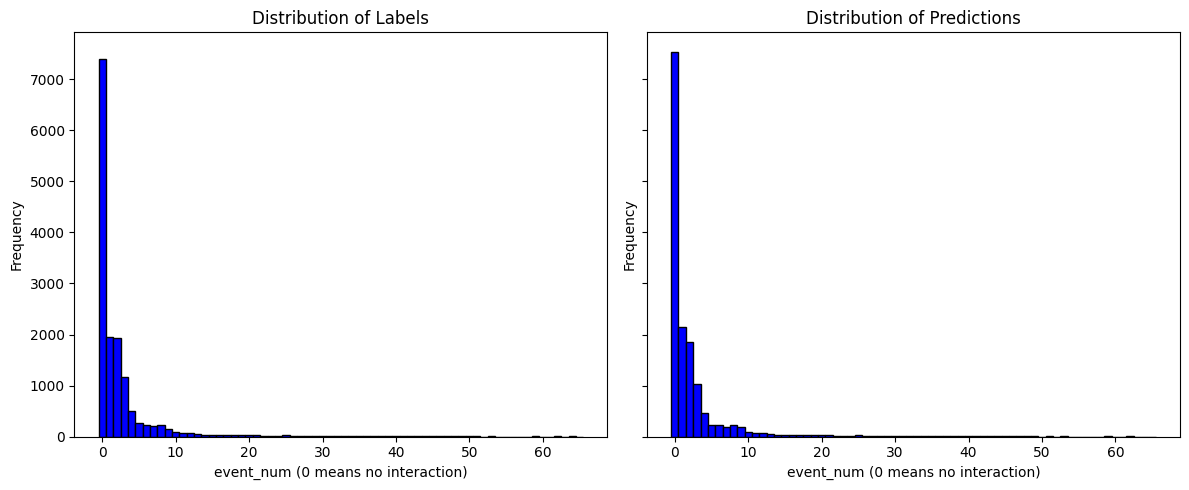

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

#labels subplot
axs[0].hist(all_labels_np, bins=range(int(min(all_labels_np)), int(max(all_labels_np)) + 2), align='left', color='blue', edgecolor='black')
axs[0].set_title('Distribution of Labels')
axs[0].set_xlabel('event_num (0 means no interaction)')
axs[0].set_ylabel('Frequency')

#predictions subplot
axs[1].hist(all_predictions_np, bins=range(int(min(all_predictions_np)), int(max(all_predictions_np)) + 2), align='left', color='blue', edgecolor='black')
axs[1].set_title('Distribution of Predictions')
axs[1].set_xlabel('event_num (0 means no interaction)')
axs[1].set_ylabel('Frequency')

#prevent overlap
plt.tight_layout()

#plot
plt.show()

ROC AUC (One vs Rest): 0.9987331073299637


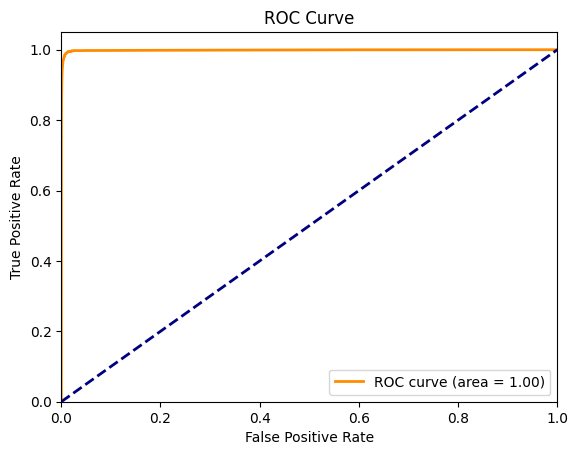

In [40]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

roc_auc_ovr = roc_auc_score(all_labels_one_hot, all_scores_np, average='micro', multi_class='ovr')
print(f'ROC AUC (One vs Rest): {roc_auc_ovr}')

#compute micro-average ROC curve and ROC area for plotting
fpr, tpr, _ = roc_curve(all_labels_one_hot.ravel(), all_scores_np.ravel())
roc_auc = auc(fpr, tpr)

#plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [41]:
# Set models to evaluation mode
all_model.eval()

all_scores = []
all_labels = []
all_predictions = []

with torch.no_grad():
    for features, labels in full_test_loader:
        all_features = features

        #set feature vectors and send them to the device
        all_features = all_features.to(device)

        #get model outputs
        all_outputs = all_model(all_features)

        #manually apply softmax to each output
        all_outputs = F.softmax(all_model(all_features), dim=1)

        #find the max as an interaction prediction
        #print(avg_outputs)
        _, y_pred = torch.max(all_outputs, dim=1)
        #print(y_pred)

        #append metrics to their respective containers
        all_scores.append(all_outputs.cpu())
        all_predictions.append(y_pred.cpu())
        all_labels.append(labels.max(dim=1)[1].cpu())

#concatenate and convert to numpy arrays
all_scores_tensor = torch.cat(all_scores, dim=0)
all_predictions_tensor = torch.cat(all_predictions, dim=0)
all_labels_tensor = torch.cat(all_labels, dim=0)

all_scores_np = torch.softmax(all_scores_tensor, dim=1).numpy()
all_predictions_np = all_predictions_tensor.numpy()
all_labels_np = all_labels_tensor.numpy()

#Use label_binarize to one hot encode
all_labels_one_hot = label_binarize(all_labels_np, classes=np.arange(event_num+1))

#calculate metrics
average_type = 'weighted'
accuracy = accuracy_score(all_labels_np, all_predictions_np)
precision = precision_score(all_labels_np, all_predictions_np, average=average_type, zero_division=0)
recall = recall_score(all_labels_np, all_predictions_np, average=average_type, zero_division=0)
f1 = f1_score(all_labels_np, all_predictions_np, average=average_type )

#ROC
roc_auc = roc_auc_score(all_labels_one_hot, all_scores_np, average='micro', multi_class='ovr')

#print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.9233194686703341
Precision: 0.924099560599272
Recall: 0.9233194686703341
F1 Score: 0.9227239811306647
ROC AUC: 0.996759806599824


## Inspect Test Outcome


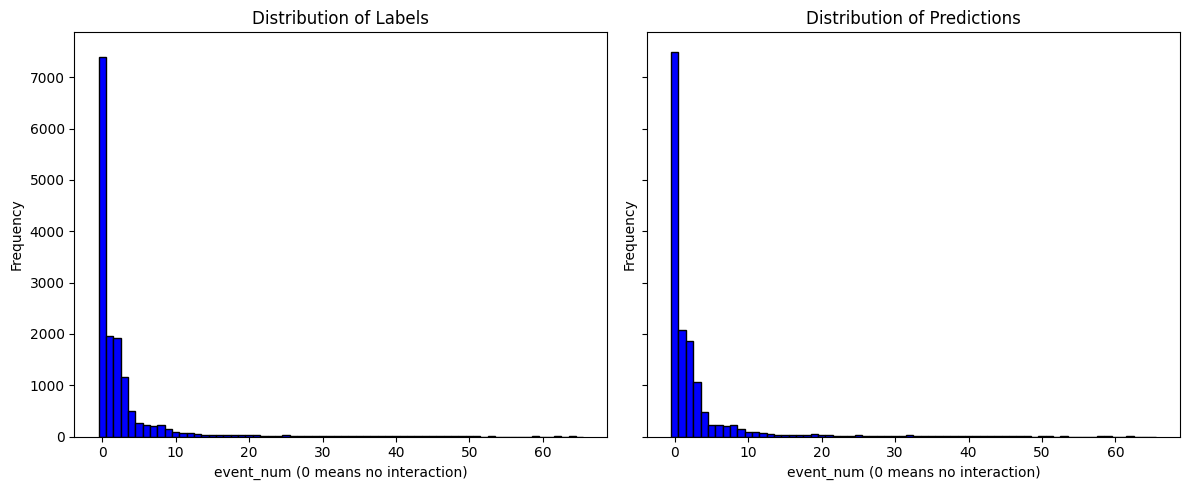

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

#labels subplot
axs[0].hist(all_labels_np, bins=range(int(min(all_labels_np)), int(max(all_labels_np)) + 2), align='left', color='blue', edgecolor='black')
axs[0].set_title('Distribution of Labels')
axs[0].set_xlabel('event_num (0 means no interaction)')
axs[0].set_ylabel('Frequency')

#predictions subplot
axs[1].hist(all_predictions_np, bins=range(int(min(all_predictions_np)), int(max(all_predictions_np)) + 2), align='left', color='blue', edgecolor='black')
axs[1].set_title('Distribution of Predictions')
axs[1].set_xlabel('event_num (0 means no interaction)')
axs[1].set_ylabel('Frequency')

#prevent overlap
plt.tight_layout()

#plot
plt.show()

ROC AUC (One vs Rest): 0.996759806599824


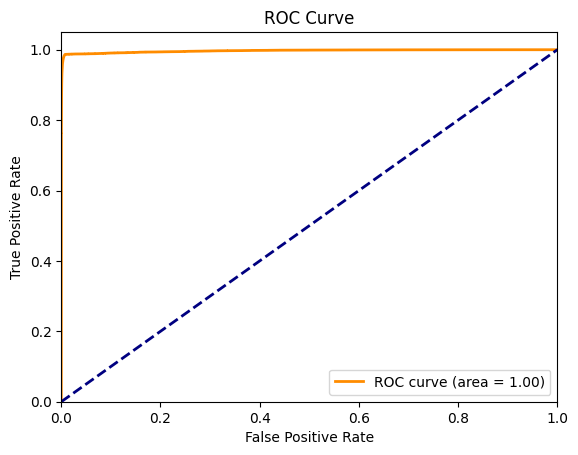

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

roc_auc_ovr = roc_auc_score(all_labels_one_hot, all_scores_np, average='micro', multi_class='ovr')
print(f'ROC AUC (One vs Rest): {roc_auc_ovr}')

#compute micro-average ROC curve and ROC area for plotting
fpr, tpr, _ = roc_curve(all_labels_one_hot.ravel(), all_scores_np.ravel())
roc_auc = auc(fpr, tpr)

#plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Results

### Reproduction Results

As shown above, we were able to replicate the results of the original experimentation with metrics similar to, and in some cases better than the original papers:

| Metric    | Our Score | Papers Score |
| --------- | --------- | ------------ |
| Accuracy  | 0.9168    | 0.9206       |
| Precision | 0.9176    | 0.9204       |
| Recall    | 0.9168    | 0.8259       |
| F1        | 0.9156    | 0.8579       |
| Roc_auc   | 0.9987    | 0.9992       |


We attribute our better results to our proper construction of the training and testing data, which now contain an even 50-50 split of positive and negative examples. The original code only trained the networks on positive samples, resulting in a skew towards predicting an interaction. This manifested in a lower Recall and F1 score. By training on both positive and negative samples, our models recognized when interactions DON'T occur, not just when they do. This resulted in significantly higher Recall and F1 scores, at the expense of a minor regression in accuracy and precision.

### Hypothesis Testing Results

As mentioned in the Scope of Reproducibility section, we posed a variety of hypothesis when experimenting with our model.

#### Parameter Tuning Results

| Parameter Tuned | Value       | Accuracy | Precision | Recall | F1     | Roc_auc |
| --------------- | ----------- | -------- | --------- | ------ | ------ | ------- |
| Layer size      | (256, 128)  | 0.8703   | 0.8674    | 0.8703 | 0.8655 | 0.9959  |
| Layer size      | (1024, 512) | 0.8966   | 0.8979    | 0.8966 | 0.8945 | 0.9971  |
| Num layers      | 3 (128)     | 0.8885   | 0.888     | 0.8885 | 0.8858 | 0.9978  |
| Num layers      | 4 (128, 64) | 0.8840   | 0.8842    | 0.8840 | 0.8815 | 0.9968  |
| Dropout Rate    | 0.1         | 0.9119   | 0.9142    | 0.9119 | 0.9118 | 0.9965  |
| Dropout Rate    | 0.5         | 0.8357   | 0.8269    | 0.8357 | 0.8225 | 0.9942  |

As shown above, adjusting the size of the model by tuning layer size and number of layers had a negative impact on model performance across the board. Recall in our data exploration, we noted a skew in drug interaction events with some being exceedingly rare. While a more complex model would better model these niche cases, we overall lose performance compared to the majority of our dataset as our model fits these niche events tighter. This fits our hypothesis, where we speculated underfitting on niche fits, however we did not expect as large of a performance drop for the majority of events.

We can observe changes in our models variance in our testing of dropout rates. A lower dropout rate (0.1) had negligible impact on our model, as we are already well generalized to the dataset due to our model's low complexity. A higher dropout rate (0.5) exacerbates this fact, making our model too generalized - thereby losing the modest fit to our training data.


#### Experiment Results

| Experiment                               | Accuracy | Precision | Recall | F1     | Roc_auc |
| ---------------------------------------- | -------- | --------- | ------ | ------ | ------- |
| Replace dropout with weight decay (0.01) | 0.8558   | 0.8528    | 0.8558 | 0.8482 | 0.9937  |
| Replace dropout with weight decay (0.05) | 0.7413   | 0.698     | 0.7413 | 0.7048 | 0.9810  |
| Replace dropout with weight decay (0.1)  | 0.7413   | 0.698     | 0.7413 | 0.7048 | 0.9810  |
| Replace dropout with weight decay (0.3)  | 0.4966   | 0.376     | 0.4966 | 0.3296 | 0.9494  |
| Replacing Adam with SGD                  | 0.7768   | 0.7455    | 0.7768 | 0.7499 | 0.9885  |

We observed a strong decrease in performance using vanilla SGD and SGD with weight decay in favor of dropout and Adam. This is counter to our hypothesis, where we anticipated weight decay to prove more performant. Performance decreased significantly with higher weight decay, matching our results in dropout experimentation. However, A low weight decay performed relatively well. SGD is notably extremely sensitive to parameters, while Adam is overall extremely robust - leading to Adams popularity. Given more hyperparameter tuning, we could potentially outperform Adam/Dropout with a fine tuned SGD optimizer. Due to the computational expense of parameter tuning, this was not a viable avenue for us to explore.


#### Ablation Results

| Ablation               | Accuracy | Precision | Recall | F1     | Roc_auc |
| ---------------------- | -------- | --------- | ------ | ------ | ------- |
| Removed Dropout Layers | 0.8929   | 0.8987    | 0.8929 | 0.8938 | 0.9952  |
| Removed Early Stopping | 0.9222   | 0.9218    | 0.9222 | 0.9212 | 0.9931  |


We tested two ablations: removal of dropout layers and removal of early stopping. Removal of dropout layers had a negative impact on performance. Since dropout is the only mechanism used by our model to inject noise, our model has little variance and a high bias to the training set. As such, it cannot generalize to new data as well.

Removal of early stopping drastically increased computation time, taking ~10x the time to perform a trial. During training, our models optimized towards a local loss minima and stayed relatively constant. This indicates that the removal of early stopping had little impact on improving our performance - rather having a negative impact as we had less computation time to explore other tuning options.





### Analyses / Discussion

##### Reproducability

The paper's experiments as provided in the github repository were reproducible but not correct. The paper inproperly generates it's training data resulting in significant leakage between datasets. There is also a disconnect between the feature matrices used in the code compared to waht is described in the paper. The paper also provides many "checkpoints" to skip parts of the code, such as pre-computed embeddings. However, modifications to the code were not easy as the repo was highly disorganized, using many undocumented, complex operations.

By rewriting the code in PyTorch, we found we could easily reproduce and modify the experiments by the original authors. The work to re-write in PyTorch was nontrivial, easily being the most difficult sections as we had to:
* Digest and understand each line of the code, without documentation
* Re-create our training data.
* Validate that our PyTorch code matched the results of the original experiments.
* Modularize the code to make each component individually runable (via feature/flags)
* Extract configuration of the various models

Once the code was rewritten in PyTorch, downstream experiments, data processing, and analysis was extremely easy. With data in more reachable formats, we could easily:
* Implement more in-depth feature analysis and plotting
* Modify the configuration of models for later experimentation

We highly recommend the original authors invest the following:
* Clear documentation of functions in the repository
* Utilizing type-hints and Mypy type analysis to ensure proper object typing
* Better documentation on each "checkpoint" (generated embeddings, models, etc), with control flags to select re-creating data or using provided models. This would simplify running modularized parts of the code, rather than the entire repo.
* A centralized entrypoint script for running each paper component individually and together.


# Citations

1. Rohani, N., Eslahchi, C. Drug-Drug Interaction Predicting by Neural Network Using Integrated Similarity. Sci Rep 9, 13645 (2019). https://doi.org/10.1038/s41598-019-50121-3

2. Lin, Xuan, et al. "KGNN: Knowledge Graph Neural Network for Drug-Drug Interaction Prediction." IJCAI. Vol. 380. 2020.

3. Al-Rabeah, M.H., Lakizadeh, A. Prediction of drug-drug interaction events using graph neural networks based feature extraction. Sci Rep 12, 15590 (2022). https://doi.org/10.1038/s41598-022-19999-4

4. Zhang, C., Lu, Y. & Zang, T. CNN-DDI: a learning-based method for predicting drug–drug interactions using convolution neural networks. BMC Bioinformatics 23 (Suppl 1), 88 (2022). https://doi.org/10.1186/s12859-022-04612-2

5. Yifan Deng, Xinran Xu, Yang Qiu, Jingbo Xia, Wen Zhang, Shichao Liu, A multimodal deep learning framework for predicting drug–drug interaction events, Bioinformatics, Volume 36, Issue 15, August 2020, Pages 4316–4322, https://doi.org/10.1093/bioinformatics/btaa501

6. Cen, Y. et al. Representation learning for attributed multiplex heterogeneous network. In Proceedings of the 25th ACM SIGKDD
International Conference on Knowledge Discovery &amp; Data Mining 1358–1368 (Association for Computing Machinery, 2019).